# Llama2

### Install necessary libraries

In [ ]:
!pip install transformers scikit-learn numpy scipy matplotlib seaborn requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 17.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 33.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 32.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.0/508.0 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 14.5 MB/s eta 0:00:00


### Load the LLama tokenizer and model

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from scipy.stats import spearmanr
import requests
import os

from huggingface_hub import login
login(token="#####################")  # Replace with the token you generated

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
model = AutoModel.from_pretrained("meta-llama/Llama-2-7b-hf")

Loading checkpoint shards: 100%|██████████| 2/2 [02:02<00:00, 61.29s/it]


In [4]:
# Function to generate embeddings for sentences using LLaMA
def generate_llama_embeddings(sentences, batch_size=32):
    embeddings = []
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i + batch_size]
        tokens = tokenizer(batch, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**tokens)
            # Use the [CLS] token embedding (or alternatively, mean-pool embeddings)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

## Classification Evaluation on MR Dataset

In [5]:
# Load SentEval's MR dataset
!git clone https://github.com/facebookresearch/SentEval.git
%cd SentEval/data/downstream
!bash get_transfer_data.bash
%cd ../../../
dataset_path = "./SentEval/data/downstream/MR"

# Load MR dataset
with open(os.path.join(dataset_path, "rt-polarity.pos"), "r") as f_pos:
    positive_samples = [line.strip() for line in f_pos.readlines()]
with open(os.path.join(dataset_path, "rt-polarity.neg"), "r") as f_neg:
    negative_samples = [line.strip() for line in f_neg.readlines()]
sentences = positive_samples + negative_samples
labels = [1] * len(positive_samples) + [0] * len(negative_samples)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.2, random_state=42)


Cloning into 'SentEval'...
remote: Enumerating objects: 691, done.
remote: Counting objects: 100% (395/395), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 691 (delta 293), reused 277 (delta 277), pack-reused 296 (from 1)
Receiving objects: 100% (691/691), 33.23 MiB | 17.29 MiB/s, done.
Resolving deltas: 100% (452/452), done.
Updating files: 100% (39/39), done.
/home/babu42/Documents/IR/SentEval/data/downstream


/home/babu42/Documents/IR/env/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Cloning Moses github repository (for tokenization scripts)...
Cloning into 'mosesdecoder'...
remote: Enumerating objects: 148459, done.
remote: Counting objects: 100% (887/887), done.
remote: Compressing objects: 100% (366/366), done.
remote: Total 148459 (delta 565), reused 797 (delta 517), pack-reused 147572 (from 1)
Receiving objects: 100% (148459/148459), 129.99 MiB | 20.56 MiB/s, done.
Resolving deltas: 100% (114591/114591), done.
Updating files: 100% (3488/3488), done.
mkdir: cannot create directory ‘.’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3716k  100 3716k    0     0  9865k      0 --:--:-- --:--:-- --:--:-- 9885k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 94916  100 94916    0     0   441k      0 --:--:-- --:--:-- --:--:--  441

/home/babu42/Documents/IR/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/babu42/Documents/IR/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/babu42/Documents/IR/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1071
           1       0.50      1.00      0.66      1062

    accuracy                           0.50      2133
   macro avg       0.25      0.50      0.33      2133
weighted avg       0.25      0.50      0.33      2133



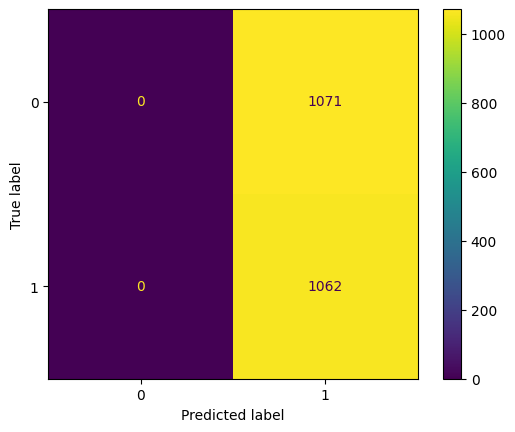

In [8]:
tokenizer.pad_token = tokenizer.eos_token
# Generate embeddings for train and test sets
X_train_embeddings = generate_llama_embeddings(X_train, batch_size=32)
X_test_embeddings = generate_llama_embeddings(X_test, batch_size=32)

# Logistic regression classifier
clf = LogisticRegression(max_iter=1000, solver='liblinear')
clf.fit(X_train_embeddings, y_train)
y_pred = clf.predict(X_test_embeddings)

# Evaluate the model
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

## STS Evaluation

In [9]:
# Load word similarity datasets
def load_and_preprocess_sts_dataset(url, columns=(0, 1, 2), delimiter="\t", skip_header=True):
    response = requests.get(url)
    lines = response.text.splitlines()
    if skip_header:
        lines = lines[1:]
    word_pairs = []
    gold_scores = []
    for line in lines:
        parts = line.split(delimiter)
        if len(parts) >= max(columns):
            try:
                word1, word2, score = parts[columns[0]], parts[columns[1]], parts[columns[2]]
                word_pairs.append((word1, word2))
                gold_scores.append(float(score))
            except ValueError:
                print(f"Skipping invalid row: {parts}")
    return word_pairs, gold_scores

In [10]:
# Dataset URLs
datasets = {
    "WS353-Sim": "https://jlu.myweb.cs.uwindsor.ca/8380/ws/WS353-Sim.txt",
    "SimLex-999": "https://jlu.myweb.cs.uwindsor.ca/8380/ws/SimLex999.txt",
    "SimVerb-3500": "https://jlu.myweb.cs.uwindsor.ca/8380/ws/SimVerb-3500.txt",
}

# Compute cosine similarity
def compute_similarity_llama(word_pairs):
    similarities = []
    for word1, word2 in word_pairs:
        word1_emb = generate_llama_embeddings([word1])[0]
        word2_emb = generate_llama_embeddings([word2])[0]
        # Cosine similarity
        similarity = np.dot(word1_emb, word2_emb) / (np.linalg.norm(word1_emb) * np.linalg.norm(word2_emb))
        similarities.append(similarity)
    return similarities

In [11]:
# Load WS353-Sim
ws353_word_pairs, ws353_gold_scores = load_and_preprocess_sts_dataset(
    datasets["WS353-Sim"], columns=(0, 1, 2), delimiter="\t", skip_header=False
)

# Load SimLex-999
simlex_word_pairs, simlex_gold_scores = load_and_preprocess_sts_dataset(
    datasets["SimLex-999"], columns=(0, 1, 2), delimiter="\t", skip_header=True
)

# Load SimVerb-3500
simverb_word_pairs, simverb_gold_scores = load_and_preprocess_sts_dataset(
    datasets["SimVerb-3500"], columns=(0, 1, 3), delimiter="\t", skip_header=True
)

# WS353-Sim
ws353_predicted_scores = compute_similarity_llama(ws353_word_pairs)

# SimLex-999
simlex_predicted_scores = compute_similarity_llama(simlex_word_pairs)

# SimVerb-3500
simverb_predicted_scores = compute_similarity_llama(simverb_word_pairs)

In [12]:
def calculate_spearman_corr(gold_scores, predicted_scores):
    correlation, _ = spearmanr(gold_scores, predicted_scores)
    return correlation

# Spearman Correlation
ws353_corr = calculate_spearman_corr(ws353_gold_scores, ws353_predicted_scores)
simlex_corr = calculate_spearman_corr(simlex_gold_scores, simlex_predicted_scores)
simverb_corr = calculate_spearman_corr(simverb_gold_scores, simverb_predicted_scores)

# Display Results
print(f"Spearman Correlation on WS353-Sim: {ws353_corr}")
print(f"Spearman Correlation on SimLex-999: {simlex_corr}")
print(f"Spearman Correlation on SimVerb-3500: {simverb_corr}")

Spearman Correlation on WS353-Sim: -0.10086001571311053
Spearman Correlation on SimLex-999: -0.03633219091140998
Spearman Correlation on SimVerb-3500: -0.03612910432900978
